# Book recommendation and Clustering project

In this project we will  cluster a large dataset of books using their descriptions and also perform similarity search to find similar books. Books descriptions will be encoded as pretrained embeddings downloaded from the [TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder-multilingual/3). Data was taken from [kaggle](https://www.kaggle.com/meetnaren/goodreads-best-books?select=book_data.csv). We will also create a simple Streamlit app where a user can select a book and get the list of similar books with descriptions.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
import re
import pickle
import nltk
from nltk.corpus import stopwords
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from collections import Counter
from sklearn.pipeline import make_pipeline
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.neighbors import NearestNeighbors
import tensorflow_hub as hub
import os
import tensorflow_text
from yellowbrick.cluster import silhouette_visualizer
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

First we have to downoad the model which will be used to encode our book descriptions into embeddings. We use here the multilingual model cause there are descriptions in multiple languagaes and this ensures that we can find similar books even if the language of description is different. Languages are detected automatically.

In [2]:
embed_multi = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

Then we have to load our data and check if there are any missing or duplicated descriptions.

In [3]:
df = pd.read_csv('book_data.csv')

In [20]:
df.head()

book_authors  \
0                                    Suzanne Collins   
1                         J.K. Rowling|Mary GrandPré   
2                                         Harper Lee   
3  Jane Austen|Anna Quindlen|Mrs. Oliphant|George...   
4                                    Stephenie Meyer   

                                           book_desc  \
0  Winning will make you famous  Losing means cer...   
1  There is a door at the end of a silent corrido...   
2  The unforgettable novel of a childhood in a sl...   
3   È cosa ormai risaputa che a uno scapolo in po...   
4  About three things I was absolutely positive F...   

                         book_edition book_format    book_isbn book_pages  \
0                                 NaN   Hardcover  9.78044E+12  374 pages   
1                          US Edition   Paperback  9.78044E+12  870 pages   
2                    50th Anniversary   Paperback  9.78006E+12  324 pages   
3  Modern Library Classics, USA / CAN   Paperback  9.78068E+12  279 pages   
4                                 NaN   Paperback  9.78032E+12  498 pages   

   book_rating  book_rating_count  book_review_count  \
0         4.33            5519135             160706   
1         4.48            2041594              33264   
2         4.27            3745197              79450   
3         4.25            2453620              54322   
4         3.58            4281268              97991   

                                  book_title  \
0                           The Hunger Games   
1  Harry Potter and the Order of the Phoenix   
2                      To Kill a Mockingbird   
3                        Pride and Prejudice   
4                                   Twilight   

                                              genres  \
0  Young Adult|Fiction|Science Fiction|Dystopia|F...   
1                        Fantasy|Young Adult|Fiction   
2  Classics|Fiction|Historical|Historical Fiction...   
3                           Classics|Fiction|Romance   
4  Young Adult|Fantasy|Romance|Paranormal|Vampire...   

                                           image_url  \
0  https://images.gr-assets.com/books/1447303603l...   
1  https://images.gr-assets.com/books/1255614970l...   
2  https://images.gr-assets.com/books/1361975680l...   
3  https://images.gr-assets.com/books/1320399351l...   
4  https://images.gr-assets.com/books/1361039443l...   

                                       book_desc_raw  
0  Winning will make you famous. Losing means cer...  
1  There is a door at the end of a silent corrido...  
2  The unforgettable novel of a childhood in a sl...  
3  «È cosa ormai risaputa che a uno scapolo in po...  
4  About three things I was absolutely positive.F...

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54301 entries, 0 to 54300
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   book_authors       54301 non-null  object 
 1   book_desc          52970 non-null  object 
 2   book_edition       5453 non-null   object 
 3   book_format        52645 non-null  object 
 4   book_isbn          41435 non-null  object 
 5   book_pages         51779 non-null  object 
 6   book_rating        54301 non-null  float64
 7   book_rating_count  54301 non-null  int64  
 8   book_review_count  54301 non-null  int64  
 9   book_title         54301 non-null  object 
 10  genres             51059 non-null  object 
 11  image_url          53618 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 5.0+ MB


In [6]:
df.isna().sum()

book_authors             0
book_desc             1331
book_edition         48848
book_format           1656
book_isbn            12866
book_pages            2522
book_rating              0
book_rating_count        0
book_review_count        0
book_title               0
genres                3242
image_url              683
dtype: int64

In [7]:
df.drop(df[df['book_desc'].isna()].index, axis=0, inplace=True)

In [9]:
df.duplicated(subset=['book_desc']).sum()

1189

In [11]:
df.duplicated(subset=['book_title']).sum()

5771

In [12]:
df.drop_duplicates(subset=['book_desc'], inplace=True)

In [13]:
df.drop_duplicates(subset=['book_title'], inplace=True)

In [14]:
df.shape

(46771, 12)

In [15]:
df.reset_index(drop=True, inplace=True)

In [16]:
df['book_desc_raw'] = df['book_desc'].copy()

Before encoding our descriptions we should also remove any punctuation.

In [17]:
df['book_desc'] = df['book_desc'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

In [21]:
df['book_desc_raw'][0]

"Winning will make you famous. Losing means certain death.The nation of Panem, formed from a post-apocalyptic North America, is a country that consists of a wealthy Capitol region surrounded by 12 poorer districts. Early in its history, a rebellion led by a 13th district against the Capitol resulted in its destruction and the creation of an annual televised event known as the Hunger Games. In punishment, and as a reminder of the power and grace of the Capitol, each district must yield one boy and one girl between the ages of 12 and 18 through a lottery system to participate in the games. The 'tributes' are chosen during the annual Reaping and are forced to fight to the death, leaving only one survivor to claim victory.When 16-year-old Katniss's young sister, Prim, is selected as District 12's female representative, Katniss volunteers to take her place. She and her male counterpart Peeta, are pitted against bigger, stronger representatives, some of whom have trained for this their whole

In [22]:
df['book_desc'][0]

'Winning will make you famous  Losing means certain death The nation of Panem  formed from a post apocalyptic North America  is a country that consists of a wealthy Capitol region surrounded by 12 poorer districts  Early in its history  a rebellion led by a 13th district against the Capitol resulted in its destruction and the creation of an annual televised event known as the Hunger Games  In punishment  and as a reminder of the power and grace of the Capitol  each district must yield one boy and one girl between the ages of 12 and 18 through a lottery system to participate in the games  The  tributes  are chosen during the annual Reaping and are forced to fight to the death  leaving only one survivor to claim victory When 16 year old Katniss s young sister  Prim  is selected as District 12 s female representative  Katniss volunteers to take her place  She and her male counterpart Peeta  are pitted against bigger  stronger representatives  some of whom have trained for this their whole

Due to the limited amount of memory we cannot encode the entire dataset at once but it has to be splitted into chunks and then concatenated. We also have to save the resulting matrix to reuse it later in the app.

In [16]:
X = [embed_multi(df['book_desc'].values[i * 2500 : (i + 1) * 2500]) for i in range(18)]

In [17]:
X_concat = np.concatenate(X + [embed_multi(df['book_desc'].values[45000:])])

In [18]:
np.save('embedding.npy', X_concat)

In [23]:
X = np.load('embedding.npy')

Now we can perform a simple similarity search using an unsupervised Neareast Neighbors algorithm with a *cosine* metric which calculates the angle between vectors in a high-dimensional space. The smaller is the angle, the more similar are the embeddings. We can also specify the number of neighbors to get. Then for a specific book we get the distances and indices of the nearest neighbors and based on the indices similar books can be listed.

In [37]:
nbrs = NearestNeighbors(metric='cosine', n_neighbors=10).fit(X)

In [38]:
distances, indices = nbrs.kneighbors(X[560].reshape(1, -1))

In [39]:
indices

array([[  560,  6617, 22389, 16961, 23934, 30844, 42266,  9939, 11379,
        30828]], dtype=int64)

In [40]:
distances

array([[0.        , 0.33737522, 0.35349107, 0.35484898, 0.36523712,
        0.3697641 , 0.37378114, 0.37542856, 0.37831032, 0.37858856]],
      dtype=float32)

In [48]:
for i in indices[0][1:]:
    print('Title: {}, Author: {}'.format(df['book_title'][i], df['book_authors'][i]))
    print(df['book_desc_raw'][i], '\n')
    print('--' * 125)

Title: Lady of Light and Shadows, Author: C.L. Wilson
She feared the dark visions and the magic within her. And she dreamed of the miraculous love that could save her.Like an enchanted fairy tale prince he stepped from the sky to claim her—the Fey King, her destiny, her one and true love.But behind the mesmerizing beauty of Rain’s violet eyes Ellysetta saw the passionate hunger of the beast . . . and a sorrow, deep and ancient, that she alone could heal. Only for him would sheembrace the frightening power that dwells within her. Only with him at her side could she confront the shadows that haunt her soul. For an epic battle looms on the horizon—and only united can they hope to turn back the armies of the darkness. 

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Title: Circles in the S

Now we can perform the clustering. For this purpose we have to search for the optimal number of clusters which can be done either using an *elbow* method or a [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) which is the mean *silhouette coefficient* over all the instances. Elbow method is based on the *inertia* metric which is the mean squared distance between each instance and its closest centroid. With increasing number of clusters inertia also decreases but from a certain point it should not drop that rapidly. This point is called an *elbow*. This method however is not so useful in all of the cases and the silhouette score gives much more information. The silhouette coefficient has a range between -1 and 1. The value close to 1 indicates that the instance is well contained inside the cluster that it was assigned to. Coeffcient close to 0 indicates that it is close to the cluster boundary and if the coefficent is close to -1 it means that the instance is probably assigned to the wrong cluster.

For clustering we also reduce the size of the embeddings so that the comparison can be done faster since silhouette score calculations are computationally expensive. For this purpose we can use PCA and preserve 95% of variance. We can see that the size of embeddings is reduced almost twice.

In [50]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

In [112]:
X.shape

(46771, 512)

In [51]:
X_reduced.shape

(46771, 273)

In [52]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

In [53]:
fig = go.Figure(data=go.Scatter(
    x = list(range(X_reduced.shape[1])),
    y = cumsum,
    mode='lines'
))

fig.update_layout(xaxis_title='Dimensions', yaxis_title='Explained Variance')

To speed up training we will use the *MiniBatchKMeans* instead of the standard algorithm which uses the full dataset.

In [178]:
models_reduced_batch = [MiniBatchKMeans(n_clusters=k, random_state=123).fit(X_reduced) for k in range(2, 100)]

In [179]:
inertia_scores_reduced_batch = [models_reduced_batch[i].inertia_ for i in range(len(models_reduced_batch))]

In [500]:
np.save('inertia_scores.npy', np.array(inertia_scores_reduced_batch))

In [54]:
inertia_scores_reduced_batch = np.load('inertia_scores.npy')

In [55]:
fig = go.Figure(data=go.Scatter(
    x = list(range(2, 100)),
    y = inertia_scores_reduced_batch,
    mode='lines'
))

fig.update_layout(xaxis_title='Number of clusters', yaxis_title='Inertia')

In [181]:
sil_scores_reduced = [silhouette_score(X_reduced, model.labels_) for model in models_reduced_batch]

In [300]:
np.save('sil_scores.npy', np.array(sil_scores_reduced))

In [56]:
sil_scores_reduced = np.load('sil_scores.npy')

In [57]:
fig = go.Figure(data=go.Scatter(
    x = list(range(2, 100)),
    y = sil_scores_reduced,
    mode='lines'
))

fig.update_layout(xaxis_title='Number of clusters', yaxis_title='Silhouette scores')

It looks like that there is no clear *elbow* visible. Also on the silhouette score plot we can see that it is not clear which number of clusters should be used. We don't want to have too many categories and at the same time it is reasonable to choose the number of clusters which gives the silhouette score larger than 0 on average. For this purpose we can perform an additionall investigation based on the *silhouette diagram* which analyses silhouette coefficients for every instance. Height of the groups shown on the plots below indicate the number of instances which belong to each cluster. We gonna analyse 7, 10, 15, 17, 19 and 25 number of clusters.

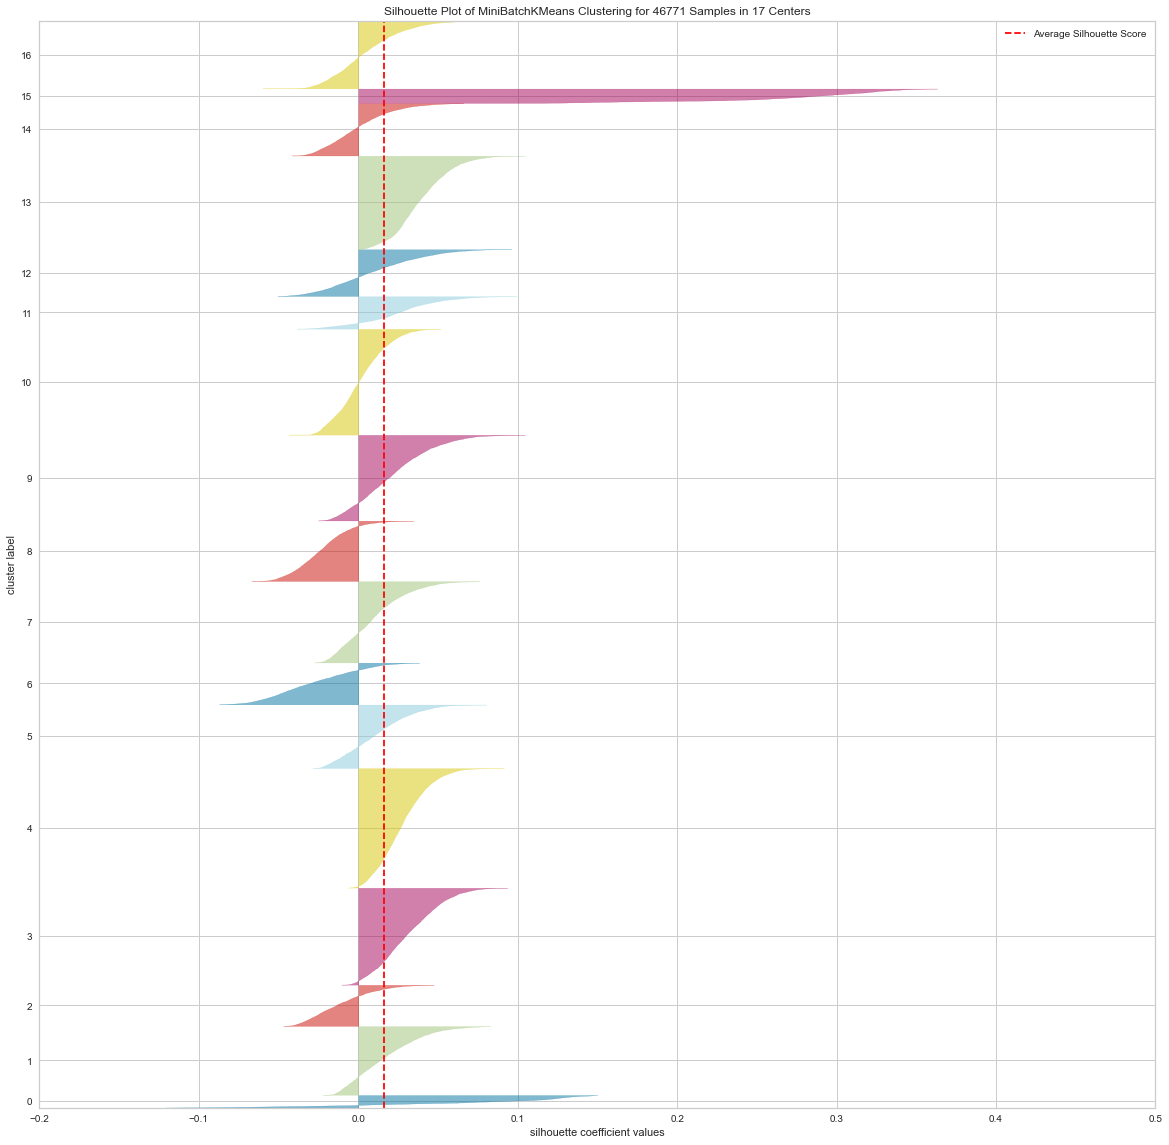

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000021424E4D400>,
                     colors='yellowbrick',
                     estimator=MiniBatchKMeans(n_clusters=17, random_state=123))

In [540]:
fig, ax = plt.subplots(figsize=(20,20))
silhouette_visualizer(MiniBatchKMeans(n_clusters=17, random_state=123), X_reduced, colors='yellowbrick', ax=ax)

In [58]:
# font_labels = 20
# font_ticks = 20
# plt.setp(ax.get_xticklabels(), fontsize=font_ticks)
# plt.setp(ax.get_yticklabels(), fontsize=font_ticks)
# ax.set_xlim(-0.2, 0.5)
# ax.legend(fontsize=font_labels)
# ax.set_ylabel('Cluster', fontsize=font_labels)
# ax.set_xlabel('Silhouette coefficient values', fontsize=font_labels)
# ax.set_title('Silhouette Plot of MiniBatchKmeans Clustering for 46771 Samples in 17 Centers', fontsize=font_labels)
# fig

In [59]:
# fig.savefig('silhouette_17.jpg', dpi=200)

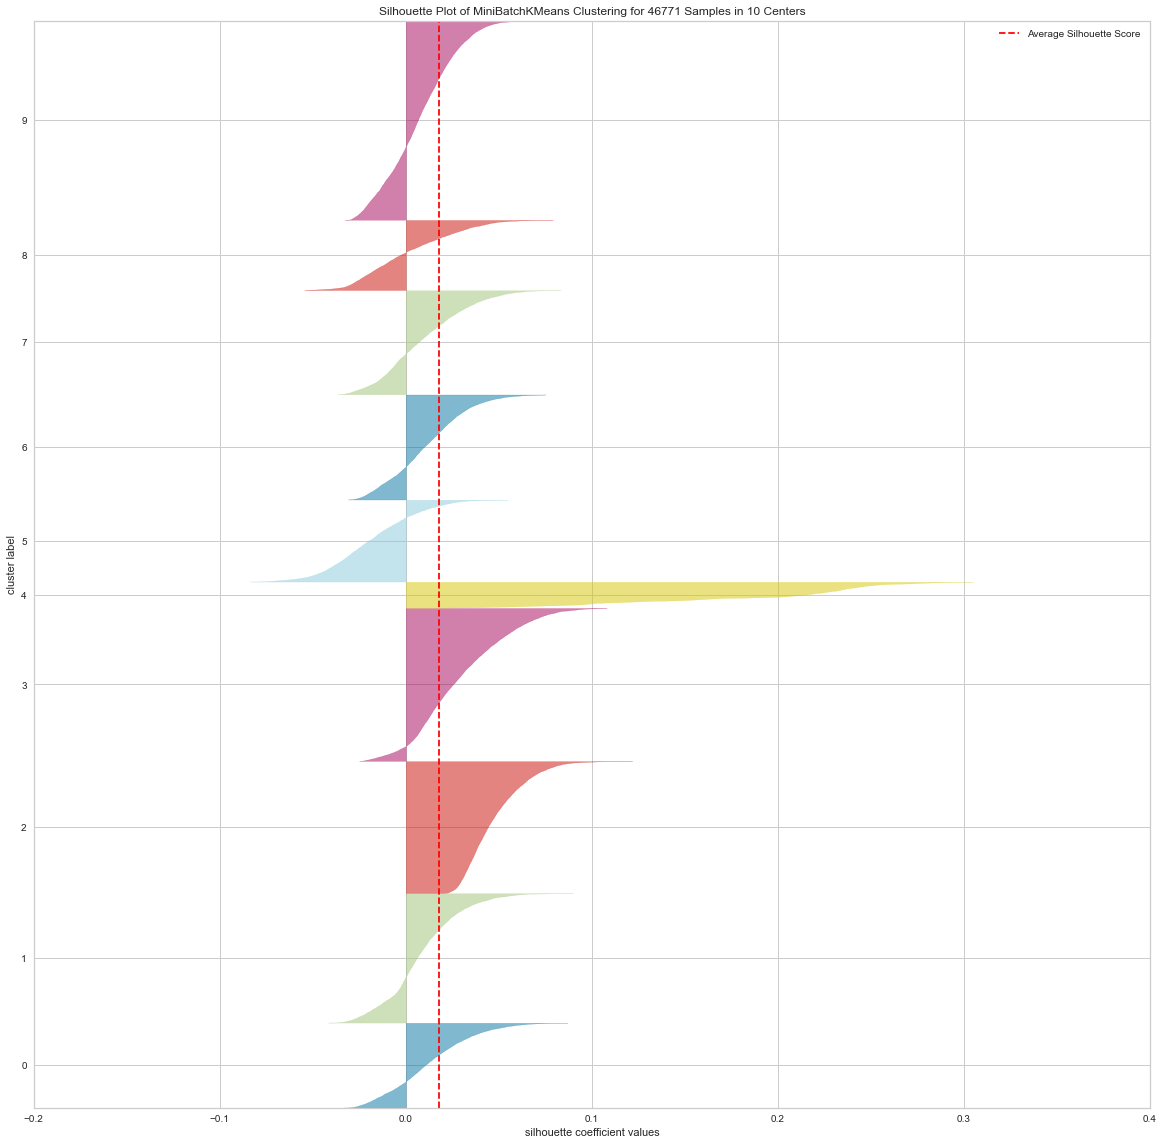

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000021394E5B070>,
                     colors='yellowbrick',
                     estimator=MiniBatchKMeans(n_clusters=10, random_state=123))

In [243]:
plt.figure(figsize=(20,20))
silhouette_visualizer(MiniBatchKMeans(n_clusters=10, random_state=123), X_reduced, colors='yellowbrick')

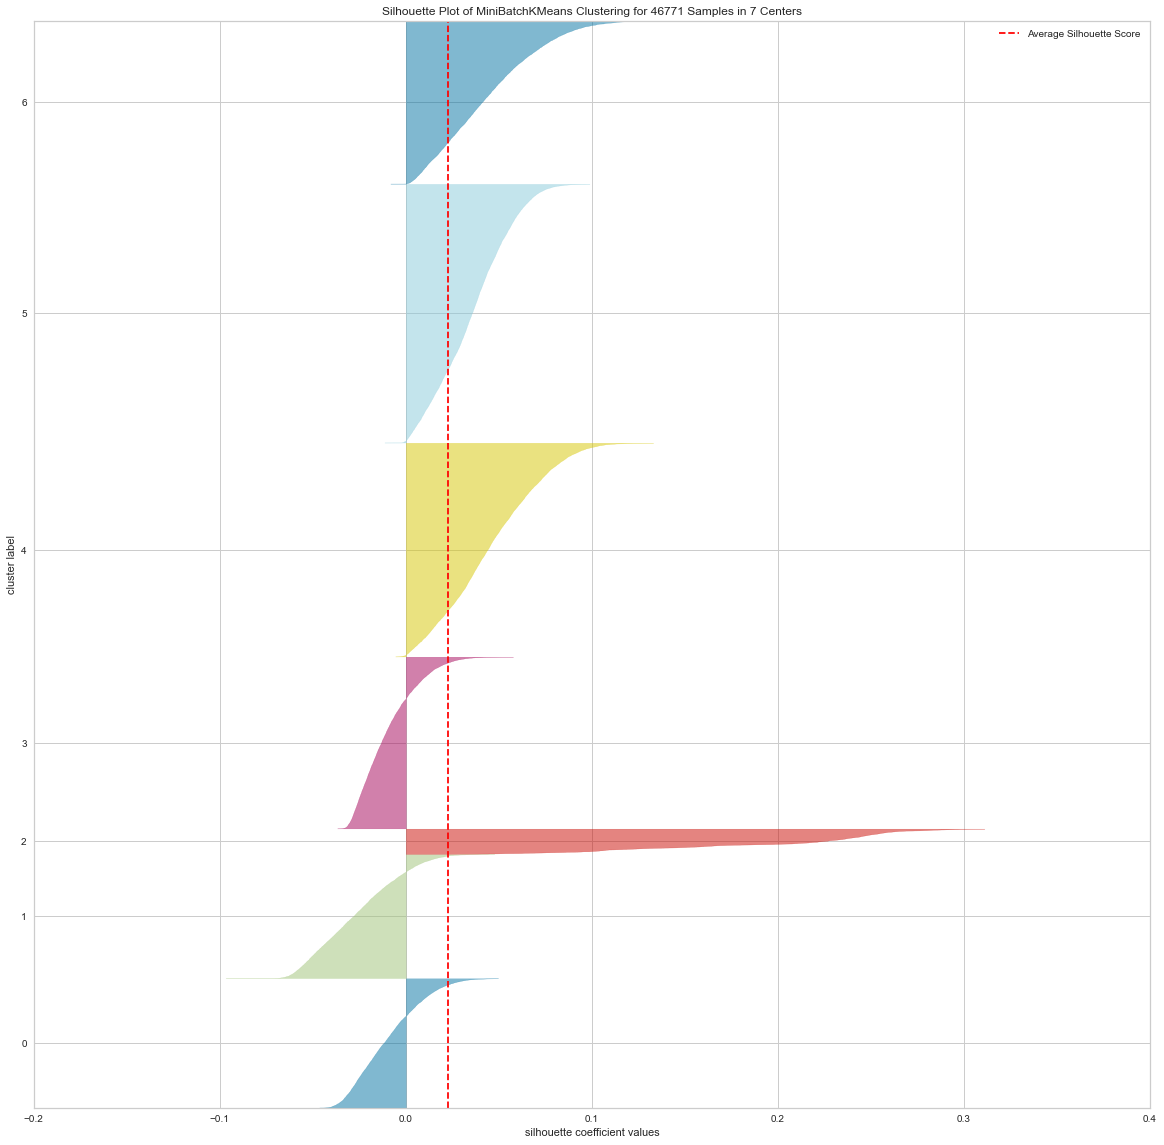

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000021394EF0DC0>,
                     colors='yellowbrick',
                     estimator=MiniBatchKMeans(n_clusters=7, random_state=123))

In [249]:
plt.figure(figsize=(20,20))
silhouette_visualizer(MiniBatchKMeans(n_clusters=7, random_state=123), X_reduced, colors='yellowbrick')

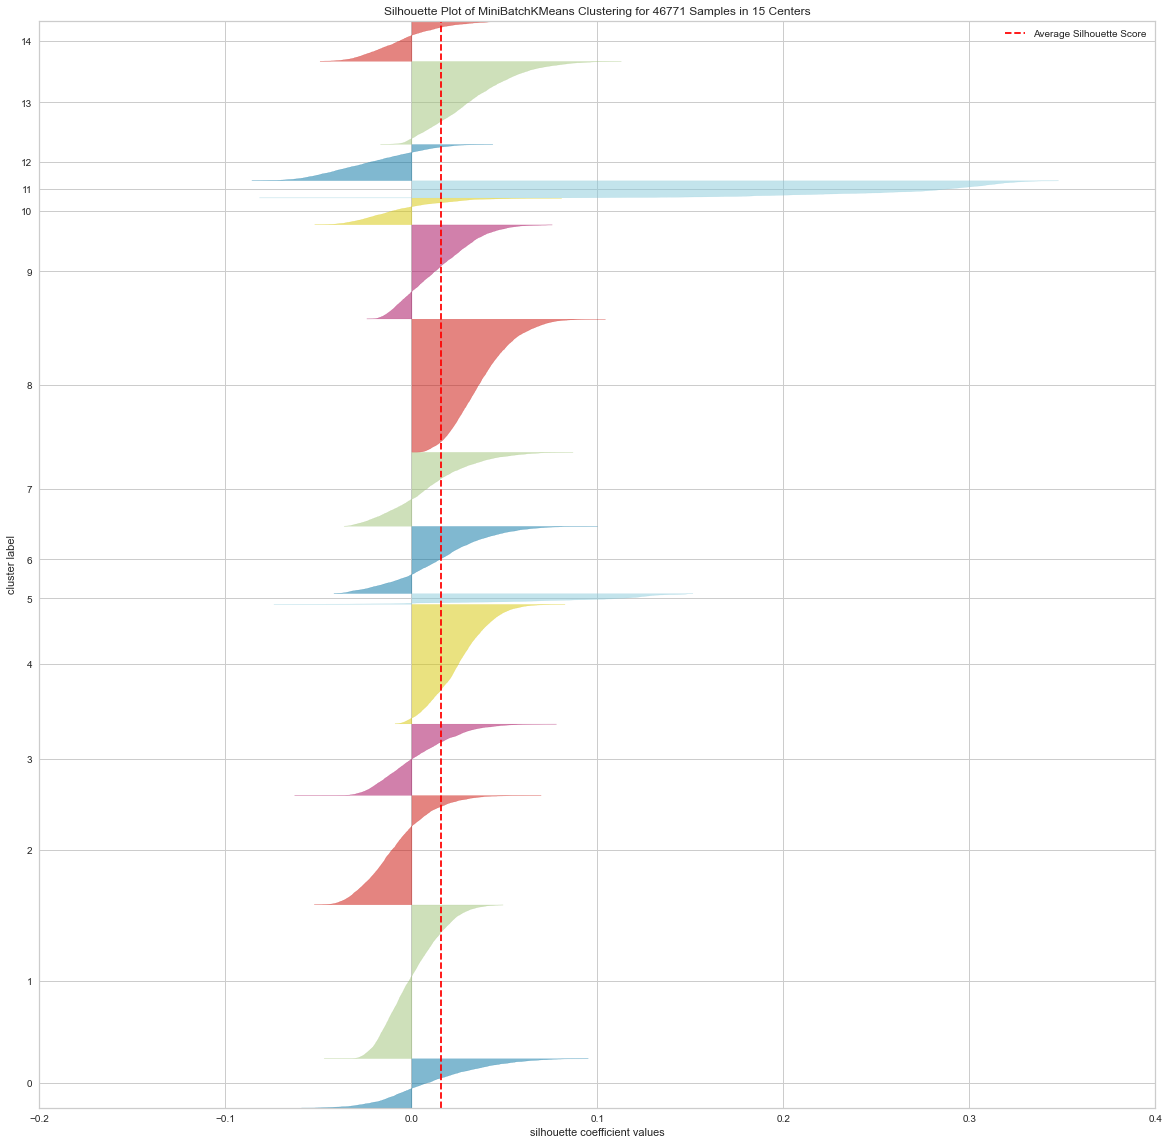

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000002138EEFE6D0>,
                     colors='yellowbrick',
                     estimator=MiniBatchKMeans(n_clusters=15, random_state=123))

In [237]:
plt.figure(figsize=(20,20))
silhouette_visualizer(MiniBatchKMeans(n_clusters=15, random_state=123), X_reduced, colors='yellowbrick')

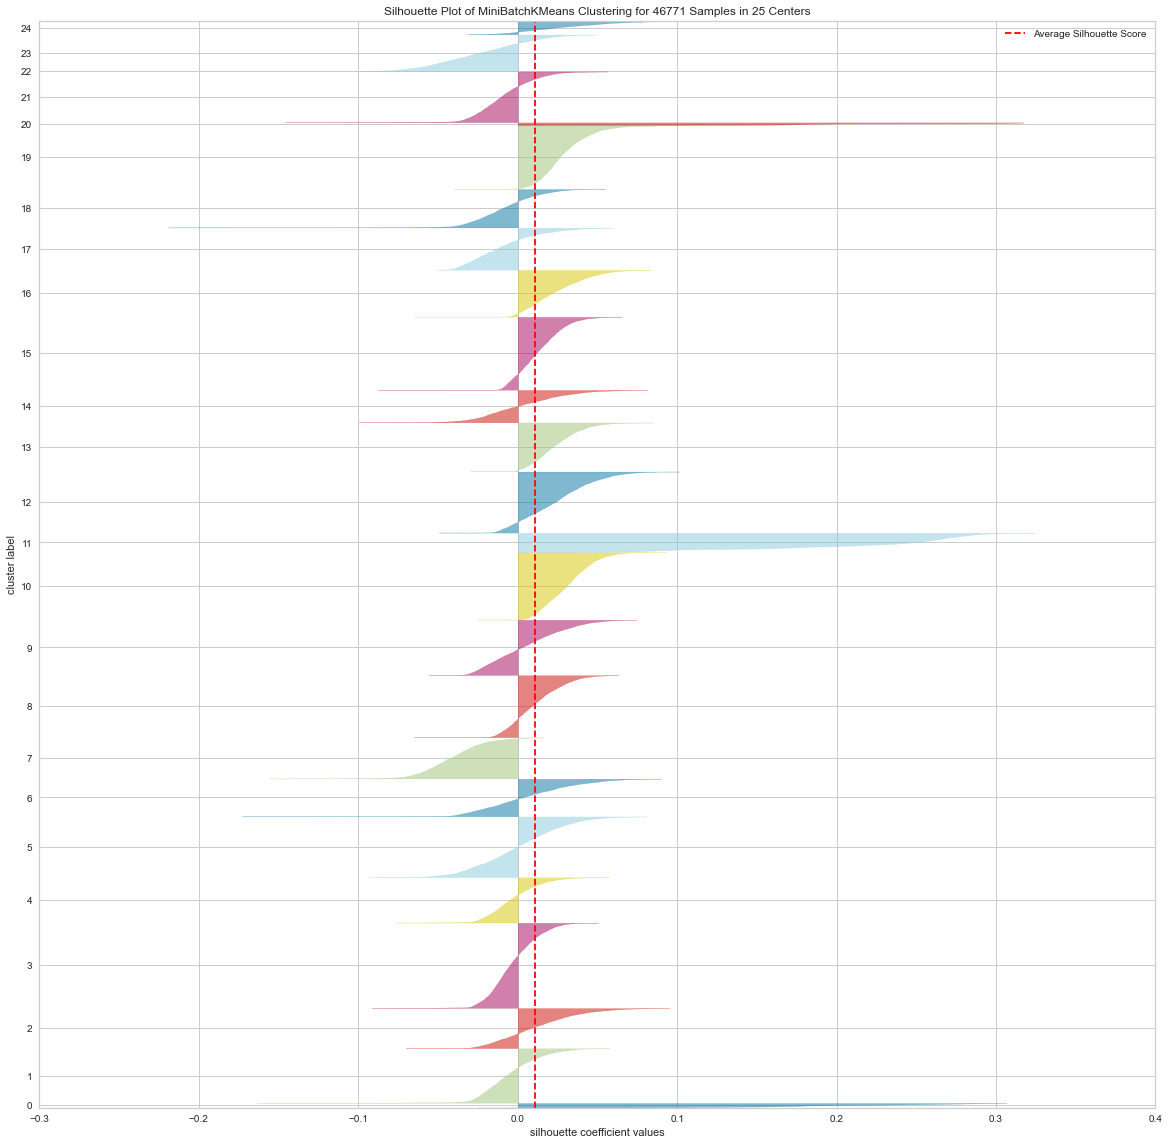

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000002138F3CB340>,
                     colors='yellowbrick',
                     estimator=MiniBatchKMeans(n_clusters=25, random_state=123))

In [355]:
plt.figure(figsize=(20,20))
silhouette_visualizer(MiniBatchKMeans(n_clusters=25, random_state=123), X_reduced, colors='yellowbrick')

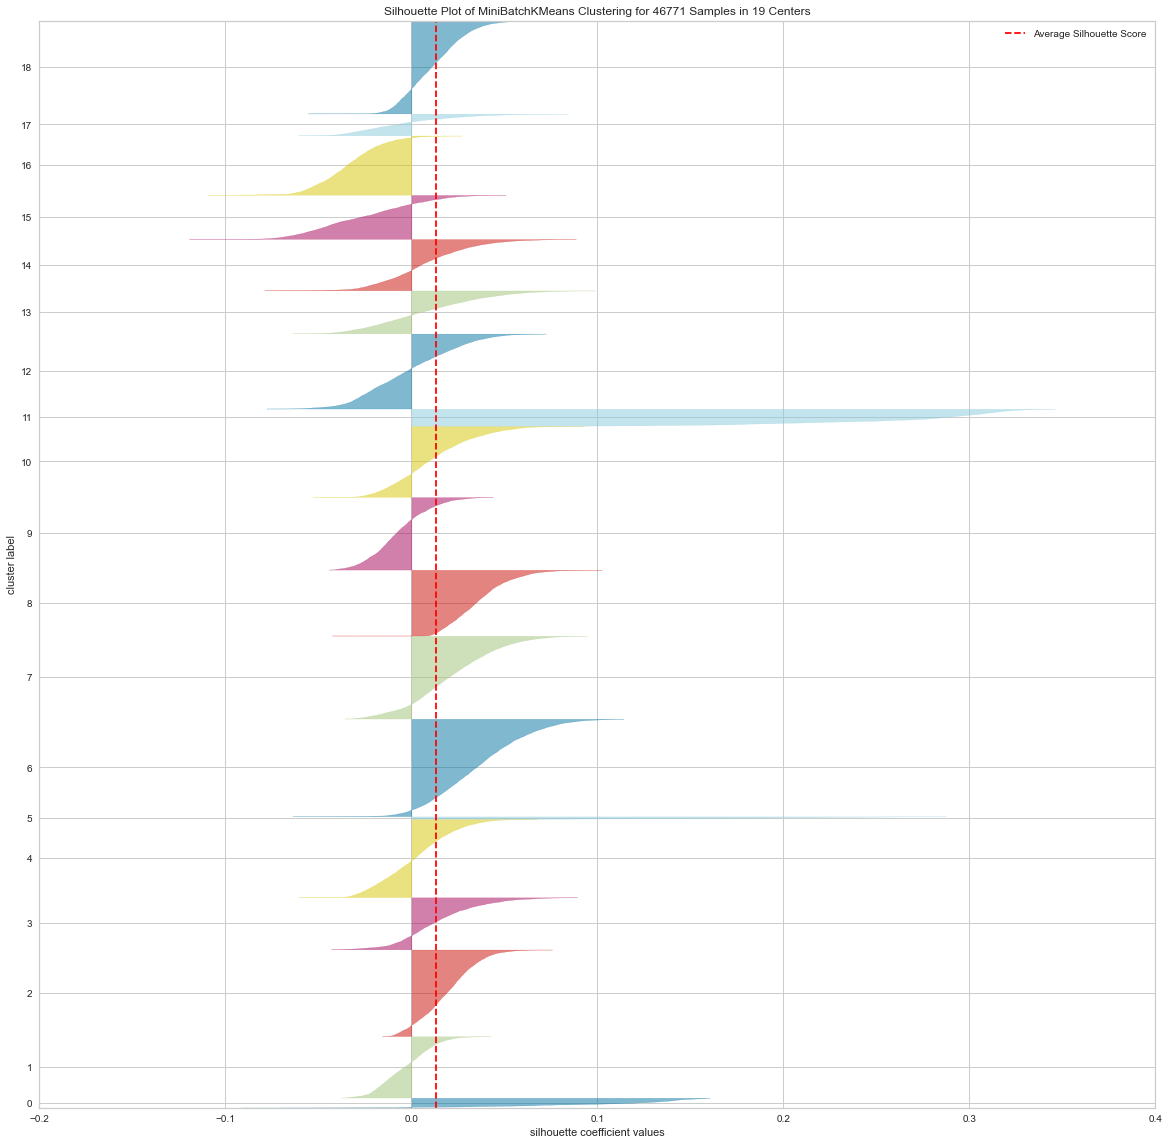

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000213FCDCFBB0>,
                     colors='yellowbrick',
                     estimator=MiniBatchKMeans(n_clusters=19, random_state=123))

In [354]:
plt.figure(figsize=(20,20))
silhouette_visualizer(MiniBatchKMeans(n_clusters=19, random_state=123), X_reduced, colors='yellowbrick')

It is hard to determine the best number of clusters. To still have a large number of groups and relatively high score compared to the neighbors we will use 17 clusters.

To visualize the clusters we can reduce the dimensions of embeddings to 2d or 3d using either a PCA or TSNE methods. To reuse calculated values in the app I will save them in a separate csv file together with books authors, titles, descriptions and assigned clusters.

In [79]:
pca_2d = PCA(n_components=2)
X_reduced_pca_2d = pca_2d.fit_transform(X)

In [80]:
pca_3d = PCA(n_components=3)
X_reduced_pca_3d = pca_3d.fit_transform(X)

In [184]:
tsne_pipe_2d = make_pipeline(PCA(n_components=50), TSNE(n_components=2))
X_reduced_tsne_2d = tsne_pipe_2d.fit_transform(X)

In [185]:
tsne_pipe_3d = make_pipeline(PCA(n_components=50), TSNE(n_components=3))
X_reduced_tsne_3d = tsne_pipe_3d.fit_transform(X)

In [296]:
np.save('tsne_3d.npy', X_reduced_tsne_3d)
np.save('tsne_2d.npy', X_reduced_tsne_2d)

In [81]:
X_reduced_tsne_3d = np.load('tsne_3d.npy')
X_reduced_tsne_2d = np.load('tsne_2d.npy')

In [82]:
kmeans = MiniBatchKMeans(n_clusters=17, random_state=123)
kmeans.fit(X_reduced)

MiniBatchKMeans(n_clusters=17, random_state=123)

In [83]:
kmeans.labels_

array([ 5,  8,  3, ..., 14,  4,  2])

In [84]:
df['cluster'] = kmeans.predict(X_reduced)

In [85]:
df_pca = df.copy()
df_pca['pca_0_2d'] = X_reduced_pca_2d[:, 0]
df_pca['pca_1_2d'] = X_reduced_pca_2d[:, 1]

df_pca['tsne_0_2d'] = X_reduced_tsne_2d[:, 0]
df_pca['tsne_1_2d'] = X_reduced_tsne_2d[:, 1]

df_pca['pca_0'] = X_reduced_pca_3d[:, 0]
df_pca['pca_1'] = X_reduced_pca_3d[:, 1]
df_pca['pca_2'] = X_reduced_pca_3d[:, 2]

df_pca['tsne_0'] = X_reduced_tsne_3d[:, 0]
df_pca['tsne_1'] = X_reduced_tsne_3d[:, 1]
df_pca['tsne_2'] = X_reduced_tsne_3d[:, 2]

In [86]:
df_pca.columns

Index(['book_authors', 'book_desc', 'book_edition', 'book_format', 'book_isbn',
       'book_pages', 'book_rating', 'book_rating_count', 'book_review_count',
       'book_title', 'genres', 'image_url', 'book_desc_raw', 'cluster',
       'pca_0_2d', 'pca_1_2d', 'tsne_0_2d', 'tsne_1_2d', 'pca_0', 'pca_1',
       'pca_2', 'tsne_0', 'tsne_1', 'tsne_2'],
      dtype='object')

In [87]:
df_pca.drop(['book_desc', 'book_edition', 'book_format', 'book_isbn', 
             'book_pages', 'book_rating', 'book_rating_count', 
             'book_review_count', 'genres', 'image_url'], axis=1, inplace=True)

In [91]:
df_pca.head()

book_authors  \
0                                    Suzanne Collins   
1                         J.K. Rowling|Mary GrandPré   
2                                         Harper Lee   
3  Jane Austen|Anna Quindlen|Mrs. Oliphant|George...   
4                                    Stephenie Meyer   

                                  book_title  \
0                           The Hunger Games   
1  Harry Potter and the Order of the Phoenix   
2                      To Kill a Mockingbird   
3                        Pride and Prejudice   
4                                   Twilight   

                                       book_desc_raw  cluster  pca_0_2d  \
0  Winning will make you famous. Losing means cer...        5 -0.027913   
1  There is a door at the end of a silent corrido...        8 -0.096659   
2  The unforgettable novel of a childhood in a sl...        3  0.236071   
3  «È cosa ormai risaputa che a uno scapolo in po...        3  0.152015   
4  About three things I was absolutely positive.F...        1  0.003736   

   pca_1_2d  tsne_0_2d  tsne_1_2d     pca_0     pca_1     pca_2     tsne_0  \
0  0.035300  -6.758110  24.747896 -0.027908  0.035326  0.196157  -6.180541   
1  0.121015  -2.184325   4.211390 -0.096656  0.121122  0.138728  12.263619   
2 -0.409749   8.522314  -0.918062  0.236073 -0.409693 -0.056034  -2.144068   
3 -0.370042  11.183734   0.903760  0.152017 -0.370004  0.011365  -6.397547   
4 -0.125020 -32.384743  32.675926  0.003740 -0.125002  0.020996  -3.419204   

      tsne_1     tsne_2  
0  -3.362738 -27.179029  
1 -11.237107 -18.323565  
2  -1.146105   8.862200  
3   0.606491   8.127826  
4  27.419773  -6.533299

In [88]:
df_pca.to_csv('books_prep.csv', index=False)

In [89]:
df_pca.groupby('cluster').size()

cluster
0      542
1     2966
2     1772
3     4182
4     5156
5     2736
6     1800
7     3509
8     2602
9     3698
10    4567
11    1400
12    2017
13    4030
14    2259
15     620
16    2915
dtype: int64

Now we can visualize our clusters and also similar books based on the similarity search performed before.

In [107]:
X_sampled = df_pca.groupby('cluster').sample(n=100, random_state=123)

In [98]:
# X_selected_clusters = pd.concat([df_pca.groupby('cluster').get_group(name) for name in [4, 6, 2]])

In [104]:
fig = px.scatter_3d(df_pca.loc[indices[0], :], x='pca_0', y='pca_1', z='pca_2',
              color='cluster', hover_name='book_title')
fig.update_layout(title='PCA decomposition', title_x=0.5)

In [108]:
fig = px.scatter_3d(X_sampled, x='tsne_0', y='tsne_1', z='tsne_2',
              color='cluster', hover_name='book_title')
fig.update_layout(title='TSNE decomposition', title_x=0.5)

In [109]:
fig = px.scatter_3d(X_sampled, x='pca_0', y='pca_1', z='pca_2',
              color='cluster', hover_name='book_title')
fig.update_layout(title='PCA decomposition', title_x=0.5)

In [110]:
fig = px.scatter(X_sampled, x="tsne_0_2d", y="tsne_1_2d", color="cluster", hover_name='book_title')
fig.update_layout(title='TSNE decomposition', title_x=0.5)

In [111]:
fig = px.scatter(X_sampled, x="pca_0_2d", y="pca_1_2d", color="cluster", hover_name='book_title')
fig.update_layout(title='PCA decomposition', title_x=0.5)